# Лабораторная работа 9. Нейронные сети.

In [7]:
import networkx as nx
import pylab
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook

# 1. Линейная регрессия 

Линейная регрессия (англ. Linear regression) — используемая в статистике регрессионная модель зависимости одной (объясняемой, зависимой) переменной y от другой или нескольких других переменных (факторов, регрессоров, независимых переменных) x с линейной функцией зависимости. (Т.е. производится интерполяция данных (x, y) с помощью линейной зависимости).


Задача обучения по прецедентам:
Есть $X$ – множество объектов (исходных данных), $Y$ – множество ответов, $f: X → Y$ – неизвестная зависимость (функция).
И известна обучающая выборка $(x^l, y^l)$. Тогда задавшись видом функции $y = f(x)$:


$$ y = k*x+b$$


можно поставить задачу об определении наиболее подходящих значений k и b.
Для её решения удобно воспользоваться следующей записью:


$$
Ap = y^l, \quad
A = \begin{pmatrix}
  x^l_1 & 1 \\
  ... & ... \\
  x^l_n & 1
\end{pmatrix}, \quad
p = (k,b)^T
$$

Это переопределённая СЛАУ, её можно решить только в смысле минимума ошибки: 

$$|Ap - y^l|^2 → min.$$

Такой подход называется «метод наименьших квадратов».

y = 1.08700e+00 * x + -1.13650e+00


<ipython-input-9-02cfd0f45e45>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  k, b = np.linalg.lstsq(A, y)[0]   # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html


<IPython.core.display.Javascript object>


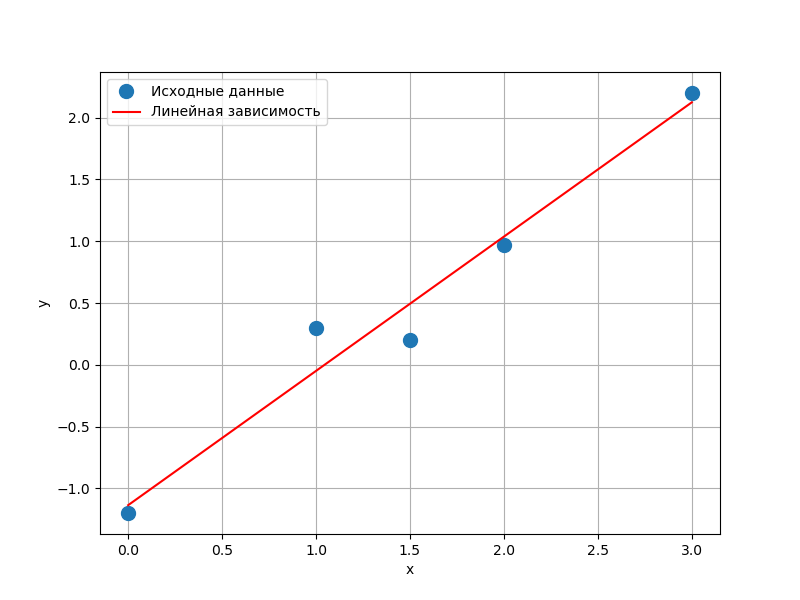

In [9]:
x = np.array([0, 1, 1.5, 2, 3])
y = np.array([-1.2, 0.3, 0.2, 0.97, 2.2])

A = np.vstack([x, np.ones(len(x))]).T

k, b = np.linalg.lstsq(A, y)[0]   # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html

print('y = %10.5e * x + %10.5e' %(k,b))

pylab.figure (figsize=(8,6))
plt.plot(x, y, 'o', label='Исходные данные', markersize=10)
plt.plot(x, k*x + b, 'r', label='Линейная зависимость')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

# Упражнение 1.

Задачу минимизации ошибки по обучающей выборке можно представить в следующем виде:

$$ e(p) = |Ap - y^l|^2 → min.$$

Это функция ошибки $e$ от параметра $p$. И для неё можно написать необходимое условие экстремума:

$$ 
e(p) = |Ap - y^l|^2 = (A^T Ap, p) - 2(A^Ty^l,p) + (y^l,y^l), \\
e'(p) = 2(A^T Ap - A^Ty^l) = 0, \\
p = (A^TA)^{-1}A^Ty^l
$$

Этот подход называется методом Гаусса – Ньютона.

Напишите подпрограмму реализующую этот метод.

(Для матричных вычислений используйте библиотеку numpy: https://docs.scipy.org/doc/numpy/reference/routines.linalg.html)

In [11]:
A_ = np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)
p = np.dot(A_,y)

print (A_)
print (f"\n {p}")

print (f"\n {k}")
print (b)


[[-3.00000000e-01 -1.00000000e-01  5.55111512e-17  1.00000000e-01
   3.00000000e-01]
 [ 6.50000000e-01  3.50000000e-01  2.00000000e-01  5.00000000e-02
  -2.50000000e-01]]

 [ 1.087  -1.1365]

 1.0870000000000002
-1.1365


# 2. Обучения отдельного нейрона

Персептрон Розенблатта. В 1957 году Розенблатт предложил эвристический алгоритм обучения нейрона, основанный на принципах, подсмотренных" в нейрофизиологии. Экспериментально было обнаружено, что при синхронном возбуждении двух связанных нервных клеток синаптическая связь между ними усиливается. Чем чаще синапс угадывает правильный ответ, тем сильнее становится связь. Своеобразная тренировка связи приводит к постепенному запоминанию информации. Если же синапс начинает часто ошибаться или вообще перестаёт использоваться, связь ослабевает, информация начинается забываться. Таким образом, память реализуется в синапсах. В математической модели нейрона роль памяти играет вектор синаптических весов w.

Заметим, что увеличивать имеет смысл только те веса $w_j$, которые соответствуют ненулевым компонентам $x^j_i$, например, можно положить $w := w + ηx_i$, где $η$ - некоторая положительная константа, называемая темпом обучения (learning rate).

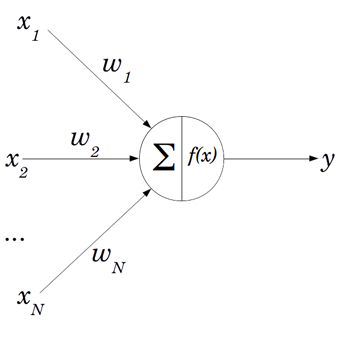

In [28]:
# Так можно добавлять картинки

from IPython.display import Image    # вызов из библиотеки определённой функции
Image("Персептрон.png")              # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

In [12]:
# метод для вычисления значения персептрона
def calc(w, x):
    res =  0
    for i in range(len(w)):
        res = res + w[i] * x[i]
    return res

# пороговая функция активации персептрона
def sign(w, x):
    if calc(w,x) > 0:
        return 1
    else:
        return -1

# обучение на одном примере
def learn(w, la, x, y):
    error = y - sign(w,x)
    if error != 0:                            # обучаем только, когда результат неверный
        for i in range(len(w)):
            w[i] = w[i] + la * error * x[i]
    return error
            
# обучение по всем данным data - кортеж примеров
def learning(w, la, data):
    for n in range(10000):
        error = 0
        for t in data:
            error += abs(learn(w, la, t[0], t[1])) # критерий обученности!! 
        if error == 0: break
        elif n == 9999: print('превышено число итераций!')

# функция для вычисления координат линии разделения множеств
def perseptron_line(x1,w):
    x2 = -(x1*w[1]+w[0])/w[2]
    return x2

# вычисление значения персептрона
def perseptron(x,w):
    return sign(w, [1]+list(x))

Создадим данные для обучения:

In [13]:
data = list()
data.append([[1.,2.,1.], 1])
data.append([[1.,3.,2.], 1])
data.append([[1.,4.,1.], 1])
data.append([[1.,1.,2.], -1])
data.append([[1.,2.,3.], -1])
data.append([[1.,5.,7.], -1])
data

[[[1.0, 2.0, 1.0], 1],
 [[1.0, 3.0, 2.0], 1],
 [[1.0, 4.0, 1.0], 1],
 [[1.0, 1.0, 2.0], -1],
 [[1.0, 2.0, 3.0], -1],
 [[1.0, 5.0, 7.0], -1]]

Зададим константу обучения:

In [14]:
la =  0.1 

Сгенерируем начальное приближение для весов:

In [15]:
w = np.random.random_sample(3)
w

array([0.84590825, 0.41591432, 0.74012282])

Проведём обучение персептрона:

In [16]:
learning(w, la, data) # обучение персептрона
print(w) # печатаем веса

[ 0.44590825  0.41591432 -0.45987718]


Визуализируем полученное решение:

In [17]:
blue_dataX1 = []
blue_dataX2 = []

red_dataX1 = []
red_dataX2 = []

for i in range(len(data)):
    if data[i][1] > 0:
        blue_dataX1.append(data[i][0][1])                
        blue_dataX2.append(data[i][0][2])
    else:
        red_dataX1.append(data[i][0][1])                
        red_dataX2.append(data[i][0][2])

In [18]:
x1 = np.linspace(min(min(blue_dataX1),min(red_dataX1)), max(max(blue_dataX1),max(red_dataX1)), 2)
x2 = perseptron_line(x1,w)

<IPython.core.display.Javascript object>


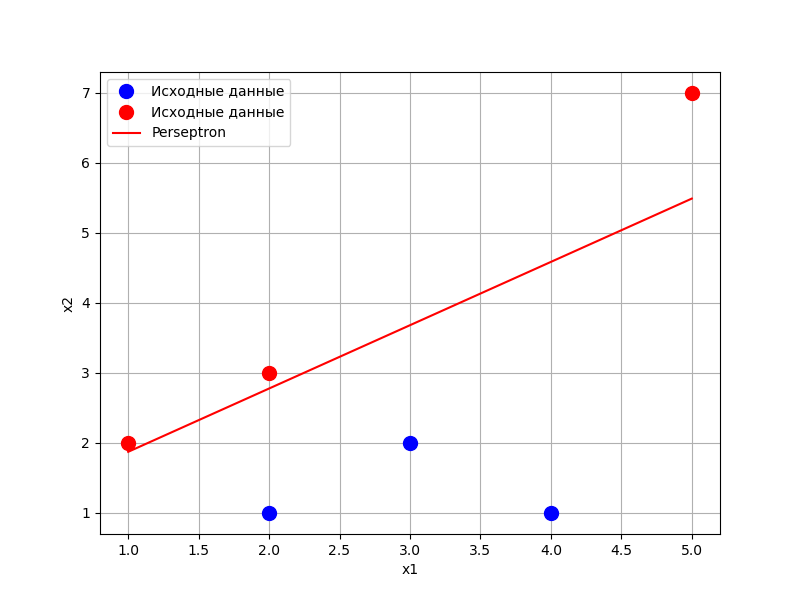

In [19]:
pylab.figure (figsize=(8,6))
plt.plot(blue_dataX1, blue_dataX2, 'o', c='b', label='Исходные данные', markersize=10)
plt.plot(red_dataX1, red_dataX2, 'o', c='r', label='Исходные данные', markersize=10)
plt.plot(x1, x2, 'r', label='Perseptron')
plt.xlabel('x1'); plt.ylabel('x2')
plt.legend(); plt.grid(True); plt.show()

In [20]:
def print_data(data, w):
    
    blue_dataX1 = []
    blue_dataX2 = []

    red_dataX1 = []
    red_dataX2 = []

    for i in range(len(data)):
        if data[i][1] > 0:
            blue_dataX1.append(data[i][0][1])                
            blue_dataX2.append(data[i][0][2])
        else:
            red_dataX1.append(data[i][0][1])                
            red_dataX2.append(data[i][0][2])
    
    x1 = np.linspace(min(min(blue_dataX1),min(red_dataX1)), max(max(blue_dataX1),max(red_dataX1)), 2)
    x2 = perseptron_line(x1,w)
    
    pylab.figure (figsize=(8,6))
    plt.plot(blue_dataX1, blue_dataX2, 'o', c='b', label='Исходные данные', markersize=10)
    plt.plot(red_dataX1, red_dataX2, 'o', c='r', label='Исходные данные', markersize=10)
    plt.plot(x1, x2, 'r', label='Perseptron')
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.legend(); plt.grid(True); plt.show()

<IPython.core.display.Javascript object>


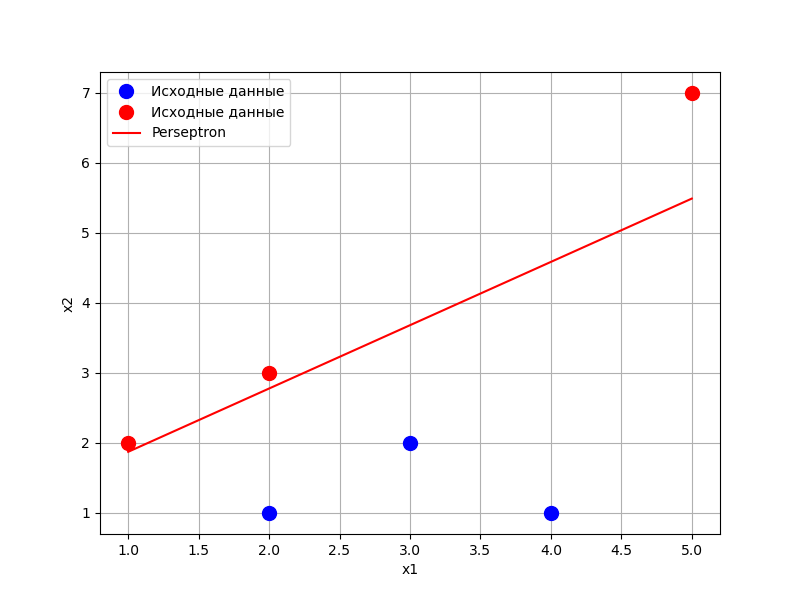

In [21]:
print_data(data, w)

In [22]:
# проверим работу на тестовых примерах
N = 10
test = np.random.uniform(1, 5, (N, 2))
p = np.zeros(N)

pb1 = []
pb2 = []

pr1 = []
pr2 = []

for i in range(N):
    p[i] = perseptron(test[i,0:2],w)
    if p[i]>0:
        pb1.append(test[i,0])                
        pb2.append(test[i,1])
    else:
        pr1.append(test[i,0])                
        pr2.append(test[i,1]) 
        
for i in range(N):
    print(test[i], p[i])

[1.68887472 4.7760766 ] -1.0
[1.56932034 1.77329776] 1.0
[2.1303525  1.94042101] 1.0
[2.26809574 3.97224343] -1.0
[4.73112173 4.91096643] 1.0
[1.87165322 3.8622315 ] -1.0
[4.19692915 1.16847222] 1.0
[2.50713507 1.33430355] 1.0
[4.04018203 3.97886257] 1.0
[4.54885409 3.07898856] 1.0


<IPython.core.display.Javascript object>


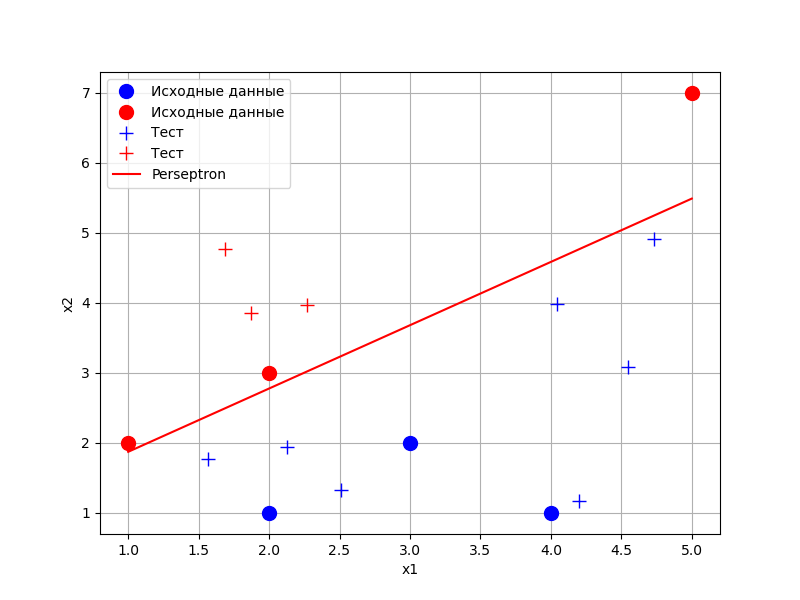

In [23]:
pylab.figure (figsize=(8,6))
plt.plot(blue_dataX1, blue_dataX2, 'o', c='b', label='Исходные данные', markersize=10)
plt.plot(red_dataX1, red_dataX2, 'o', c='r', label='Исходные данные', markersize=10)
plt.plot(pb1, pb2, '+', c='b', label='Тест', markersize=10)
plt.plot(pr1, pr2, '+', c='r', label='Тест', markersize=10)
plt.plot(x1, x2, 'r', label='Perseptron')
plt.xlabel('x1'); plt.ylabel('x2')
plt.legend(); plt.grid(True); plt.show()

In [24]:
def TEST(w, N=10, test = True):
    
    # проверим работу на тестовых примерах
    if test: test = np.random.uniform(1, 5, (N, 2))
    p = np.zeros(N)

    pb1 = []
    pb2 = []

    pr1 = []
    pr2 = []

    for i in range(N):
        p[i] = perseptron(test[i,0:2],w)
        if p[i]>0:
            pb1.append(test[i,0])                
            pb2.append(test[i,1])
        else:
            pr1.append(test[i,0])                
            pr2.append(test[i,1]) 

    for i in range(N):
        print(test[i], p[i])
        
    pylab.figure (figsize=(8,6))
    plt.plot(blue_dataX1, blue_dataX2, 'o', c='b', label='Исходные данные', markersize=10)
    plt.plot(red_dataX1, red_dataX2, 'o', c='r', label='Исходные данные', markersize=10)
    plt.plot(pb1, pb2, '+', c='b', label='Тест', markersize=10)
    plt.plot(pr1, pr2, '+', c='r', label='Тест', markersize=10)
    plt.plot(x1, x2, 'r', label='Perseptron')
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.legend(); plt.grid(True); plt.show()

[3.09892223 4.52918463] -1.0
[4.28359407 2.31628363] 1.0
[2.10120928 1.34990859] 1.0
[1.9706214  3.09201579] -1.0
[2.8367412 1.217065 ] 1.0
[4.12155425 3.07413366] 1.0
[1.52343291 4.83633551] -1.0
[1.16479692 4.68065173] -1.0
[4.27687278 1.53068252] 1.0
[2.7906455  4.70371861] -1.0
[2.51914256 3.5527582 ] -1.0


<IPython.core.display.Javascript object>


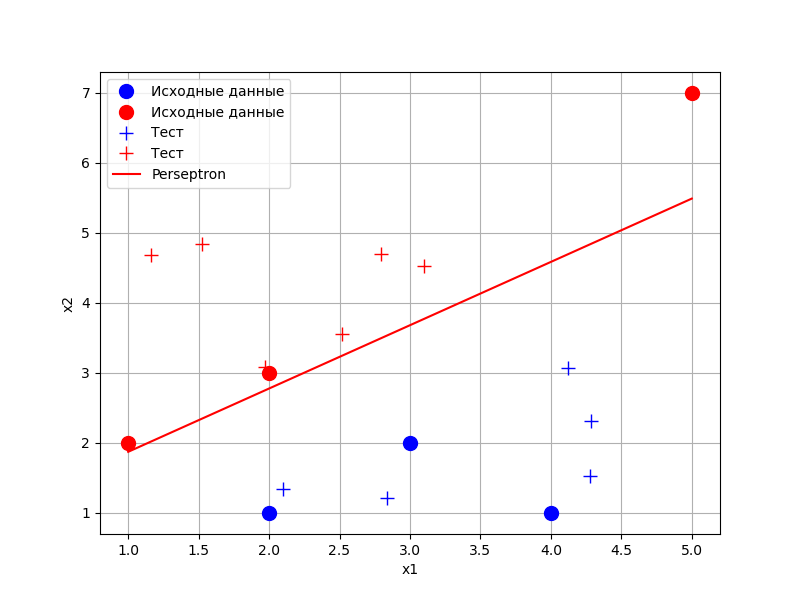

In [25]:
test = np.array([[3.64323462, 1.24003704], [3.45746066, 2.42179317]])

#TEST(w, 2, test)
TEST(w, 11)

# Упражнение 2.

Попробуёте использовать Персептрон для решения задач логических AND, OR и XOR. Визуализируйте полученный результат.

AND: 
data = [[[1, 0, 0], 0],
        [[1, 0, 1], 0],
        [[1, 1, 0], 0],
        [[1, 1, 1], 1]];
 
и т.д.

[0.57055524 0.13780007 0.97850718]
превышено число итераций!
[-0.02944476  0.33780007  0.17850718]


<IPython.core.display.Javascript object>


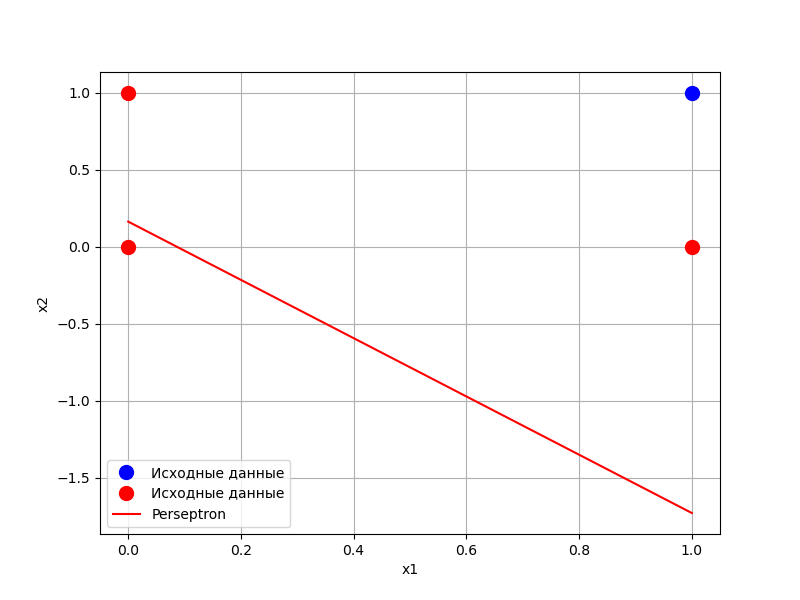

In [26]:
la =  0.1 
dataAND = [[[1, 0, 0], 0], [[1, 0, 1], 0], [[1, 1, 0], 0], [[1, 1, 1], 1]]

w = np.random.random_sample(3)
print(w) # печатаем веса

learning(w, la, dataAND) # обучение персептрона

print(w) # печатаем веса

print_data(dataAND, w)



In [27]:
# OR не работает для одномерного случая

la =  0.1 
dataOR = [[[1, 0, 0], 1], [[1, 0, 1], 1], [[1, 1, 0], 1], [[1, 1, 1], 1]]

w = np.random.random_sample(3)
print(w) # печатаем веса

learning(w, la, dataOR) # обучение персептрона
print(w) # печатаем веса

print_data(dataOR, w)


[0.75086881 0.64323714 0.56450299]
[0.75086881 0.64323714 0.56450299]


ValueError: min() arg is an empty sequence

# Как вы и говорили для одного из трех это не сработает)

[0.76636405 0.78584172 0.34456175]
превышено число итераций!
[ 0.36636405 -0.01415828 -0.05543825]


<IPython.core.display.Javascript object>


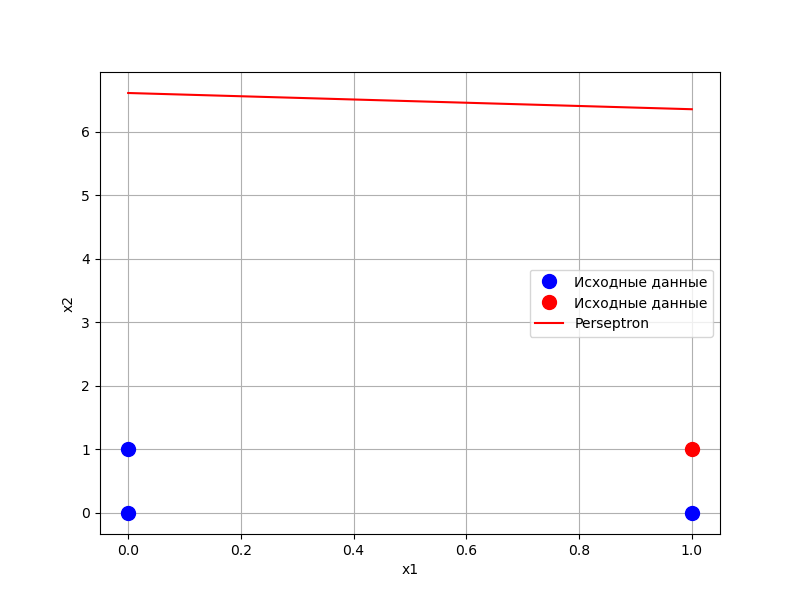

In [28]:
la =  0.1 

dataXOR = [[[1, 0, 0], 1], [[1, 0, 1], 1], [[1, 1, 0], 1], [[1, 1, 1], 0]]

w = np.random.random_sample(3)
print(w) # печатаем веса

learning(w, la, dataXOR) # обучение персептрона
print(w) # печатаем веса

print_data(dataXOR, w)


# 3. Многослойные нейронные сети.

Рассмотрим композицию нейронов. Значения всех n признаков одновременно подаются на вход всех H нейронов первого слоя. Затем их выходные значения подаются на вход всех M нейронов следующего слоя. В данном случае этот слой является выходным такая сеть называется двухслойной. В общем случае сеть может содержать произвольное число слоёв. Все слои, за исключением последнего, называются скрытыми (hidden layers).

Многослойные сети также можно настраивать градиентными методами, несмотря на огромное количество весовых коэффициентов. Известен весьма эффетивный способ вычисления градиента, при котором каждый градиентный шаг выпол няется за число операций, лишь немногим большее, чем при обычном вычислении сети на одном объекте.

На первый взгляд, количество операций, необходимых для вычисления градиента, должно было бы возрасти пропорционально числу весовых коэффициентов. Однако этого удаётся избежать путём аналитического дифференцирования суперпозиции с сохранением всех необходимых промежуточных величин. Данный метод получил название обратного распространения ошибок (error back-propagation).


# Метод обратного распространения ошибок

Рассмотрим многослойную сеть, в который каждый нейрон предыдущего слоя связан со всеми нейронами последующего слоя. Для большей общности положим $X = R^n, Y = R^m$.

Введём следующие обозначения. Пусть выходной слой состоит из M нейронов с функциями активации $f_m$ и выходами $y^m, m = 1,...,M$. Перед ним находится скрытый слой из H нейронов с функциями активации $f_h$ и выходами $u^h, h = 1,...,H$.
Веса синаптических связей между $h-м$ нейроном скрытого слоя и m-м нейроном выходного слоя будем обозначать через $w_{hm}$. Перед этим слоем может находиться либо распределительный слой, либо ещё один скрытый слой с выходами $v^j , j = 1,..., J$
и синаптическими весами $w_{jh}$. В общем случае число слоёв может быть произвольным. 

На рисунке ниже приведён пример с двумя внутренними слоями, в котором в первом слое 3 нейрона (1,2,3), во втором 2 нейрона (4,5), а в выходном один (6). Рисунок показывает процесс вычислений в рамках метода обратного распространения ошибок.

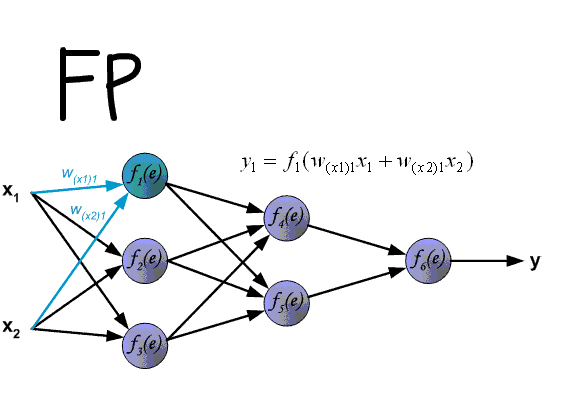

In [37]:
# Так можно добавлять картинки

from IPython.display import Image    # вызов из библиотеки определённой функции
Image("МОРО.gif")                    # вызов функции и передача ей в качестве аргумента пути к файлу 

# (в данном случае фаил находится в той же папке)

Алгоритм обучения двухслойной сети методом обратного распространения ошибки:
(Вход: $(x^l,y^l)$ - обучающее множество данных, H - число нейронов в скрытом слое, la - темп обучения; Выход: синаптические веса $w_{jh}, w_{hm}$)


1. Инициализировать веса небольшими случайными значениями: 
$$ w_{jh} = random(−1/2n, 1/2n);
w_{hm} = random(-1/2H, 1/2H); $$
2. Выбрать $x_i$;
3. Прямой ход - вычислить: 
$$u^{h}(x_{i}) = f(x_{i}, w_{jh}), \quad u^{\prime h}(x_{i}) = f(x_{i}, w_{jh})(1-f(x_{i}, w_{jh}))$$
$$ y^m(x_i) = f(u^h(x_i), w_{hm}), \quad y^{^\prime m}(x_i) = f(u^h(x_i), w_{hm})(1-f(u^h(x_i), w_{hm})) $$
$$ e^m = y^m(x_i) - y^m_i, \quad Q_i = \sqrt{e^m*e^m} $$
4. Обратный ход - вычислить:
$$ e^h = e^m y^{^\prime m}(x_i) w_{hm} $$
5. Градиентный шаг:
$$ w_{hm} = w_{hm} - la e^m y^{^\prime m}(x_i) u^h(x_i) $$
$$ w_{jh} = w_{jh} - la e^h y^{^\prime h}(x_i) x_i $$
(Повторять пункты 2 - 5 пока sum(Q_i) > error.)

# Упражнение 3. 

Напишите программы для обучения и использования двухслойной нейронной сети.

Используйте при этом следующую функцию активации и её производную:

In [29]:
# активационная функция (1/(e^(-x)))
from scipy.special import expit
def f(x):
    return sp.expit(x)

# производная активационной функции
def f1(x):
    return x * (1 - x)

In [30]:
from random import choice
from numpy import array, dot, random

unit_step = lambda x: 0 if x < 0 else 1

training_data = [
    (array([0,0,1]), 0),
    (array([0,1,1]), 1),
    (array([1,0,1]), 1),
    (array([1,1,1]), 1),
]

w = random.rand(3)
errors = []
eta = 0.2
n = 100

for i in range(n):
    x, expected = choice(training_data)
    result = dot(w, x)
    error = expected - unit_step(result)
    errors.append(error)
    w += eta * error * x

for x, _ in training_data:
    result = dot(x, w)
    print("{}: {} -> {}".format(x[:2], result, unit_step(result)))

[0 0]: -0.11518028060441798 -> 0
[0 1]: 0.4012569923832858 -> 1
[1 0]: 0.43646719084363605 -> 1
[1 1]: 0.9529044638313399 -> 1


In [31]:
import random
import numpy as np

def BackPropagation(x, y, n, H, la):
    w_jh = random.uniform(-0.5 * n, 0.5 * n)
    w_hm = random.uniform(-0.5 * H, 0.5 * H)
    #while sum(Q_i) > error:
    
    u_h = f(np.dot(x, w_jh))
    u_h_ = f1(f(np.dot(x, w_jh)))
    y_m = f(np.dot(u_h, w_hm))
    y_m_ = f1(f(np.dot(u_h, w_hm)))
    e_m = y_m - y_m_
    Q_i = np.sqrt(np.dot(e_m, e_m)).sum()
    #print(Q_i)
    while Q_i > 0:
        u_h = f(np.dot(x, w_jh))
        u_h_ = f1(f(np.dot(x, w_jh)))
        y_m = f(np.dot(u_h, w_hm))
        y_m_ = f1(f(np.dot(u_h, w_hm)))
        e_m = y_m - y_m_
        Q_i = np.sqrt(np.dot(e_m, e_m))
        e_h = e_m * y_m_ * w_hm
        w_hm = w_hm - la * e_m * y_m_ * u_h
        w_jh = w_jh - la * e_h * u_h_ * x
        return w_jh, w_hm
 
    
x = np.array([0, 1, 1.5, 2, 3])
y = np.array([-1.2, 0.3, 0.2, 0.97, 2.2])
BackPropagation(x, y, 10, 100, 0.03)

NameError: name 'sp' is not defined

# Упражнение 4.

Попробуёте использовать двуслойную нейронную сеть для решения задач логических AND, OR и XOR. Визуализируйте полученный результат.

AND: 
data = [[[1, 0, 0], 0],
        [[1, 0, 1], 0],
        [[1, 1, 0], 0],
        [[1, 1, 1], 1];
 
и т.д.

In [2]:
from random import choice
from numpy import array, dot, random

unit_step = lambda x: 0 if x < 0 else 1

training_data = [
    (array([0,0,1]), 1),
    (array([0,1,1]), 1),
    (array([1,0,1]), 1),
    (array([1,1,1]), 1),
]

w = random.rand(3)
errors = []
eta = 0.2
n = 100

for i in range(n):
    x, expected = choice(training_data)
    result = dot(w, x)
    error = expected - unit_step(result)
    errors.append(error)
    w += eta * error * x

for x, _ in training_data:
    result = dot(x, w)
    print("{}: {} -> {}".format(x[:2], result, unit_step(result)))

[0 0]: 0.548552072703675 -> 1
[0 1]: 1.1126070772510777 -> 1
[1 0]: 1.0662927060987855 -> 1
[1 1]: 1.630347710646188 -> 1


In [1]:
from random import choice
from numpy import array, dot, random

unit_step = lambda x: 0 if x < 0 else 1

training_data = [
    (array([0,0,1]), 0),
    (array([0,1,1]), 1),
    (array([1,0,1]), 1),
    (array([1,1,1]), 0),
]

w = random.rand(3)
errors = []
eta = 0.2
n = 100

for i in range(n):
    x, expected = choice(training_data)
    result = dot(w, x)
    error = expected - unit_step(result)
    errors.append(error)
    w += eta * error * x

for x, _ in training_data:
    result = dot(x, w)
    print("{}: {} -> {}".format(x[:2], result, unit_step(result)))

[0 0]: -0.12587192722256219 -> 0
[0 1]: -0.16786521283480993 -> 0
[1 0]: -0.09282843908913696 -> 0
[1 1]: -0.1348217247013847 -> 0


# 4. Генерация данных

Для тестирования работоспособности нейронных сетей рассмотри различные пары множеств эллементов.

In [2]:
def plot_model_data(blue_data, red_data):
    pl.figure(figsize=(10, 10))
    pl.scatter(blue_data[:,0], blue_data[:,1], color="blue", alpha=0.3)
    pl.scatter(red_data[:,0], red_data[:,1], color="red", alpha=0.3)
    pl.show()

In [3]:
def generate_linear(point_count, slope, constant):
    points = np.random.rand(point_count, 2)
    above_index = slope * points[:, 0] + constant < points[:, 1]
    blue_data = points[above_index, :]
    red_data = points[~above_index, :]
    return blue_data, red_data

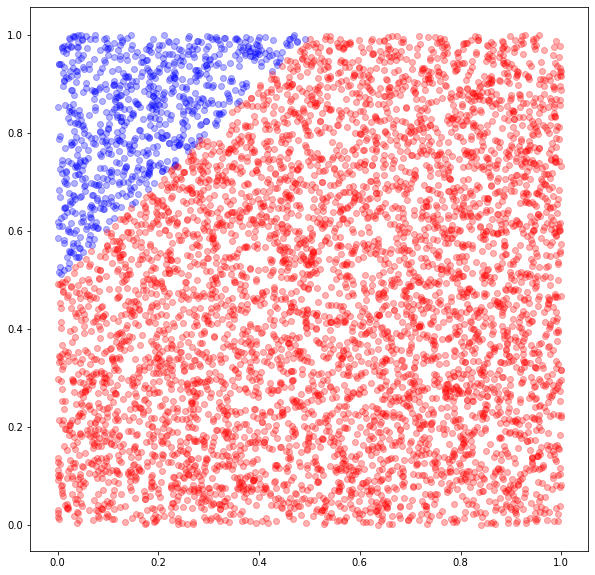

In [4]:
linear1, linerate2 = generate_linear(6000, 1, 0.5)
plot_model_data(linear1, linerate2)

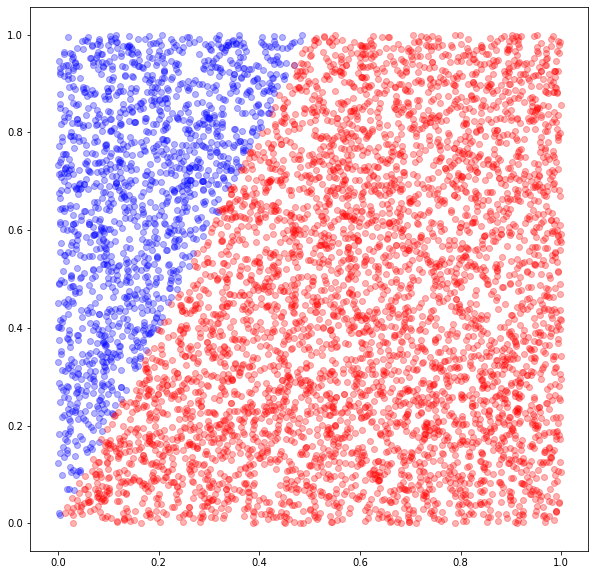

In [5]:
linear1, linerate2 = generate_linear(6000, 2, 0.0)
plot_model_data(linear1, linerate2)

In [6]:
def generate_circle(point_count, center, radius = 0.25):
    points = np.random.rand(point_count, 2)
    x, y = center
    inside_index = (points[:, 0] - x)**2 + (points[:, 1] - y)**2 <= (radius)**2
    blue_data = points[inside_index, :]
    red_data = points[~inside_index, :]
    return blue_data, red_data

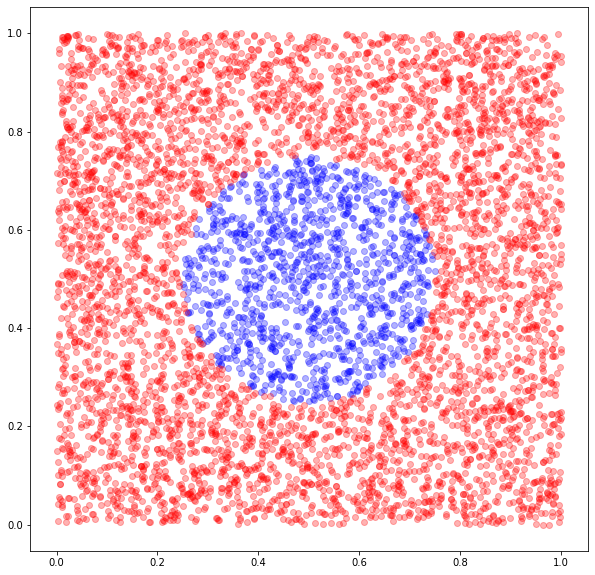

In [7]:
blue_data, red_data = generate_circle(6000, (0.5, 0.5))
plot_model_data(blue_data, red_data)

In [8]:
def generate_saw(point_count, width, height):
    points = np.random.rand(point_count, 2)
    subsaw_index = (points[:, 0] / width).astype(int)
    unit = points[:, 0] - subsaw_index * width
    below_index = points[:, 1] < 0.5 - 2.0 * (subsaw_index % 2 - 0.5) * (unit * 2 * height / width - height)
    blue_data = points[below_index, :]
    red_data = points[~below_index, :]
    return blue_data, red_data

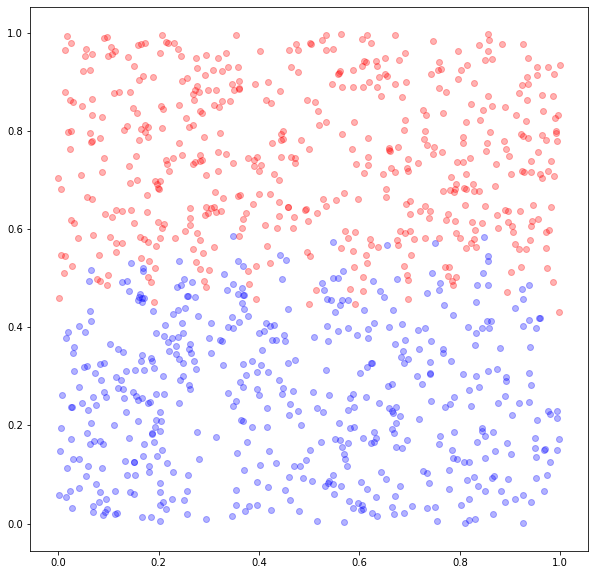

In [9]:
blue_data, red_data = generate_saw(1000, 0.05, 0.1)
plot_model_data(blue_data, red_data)

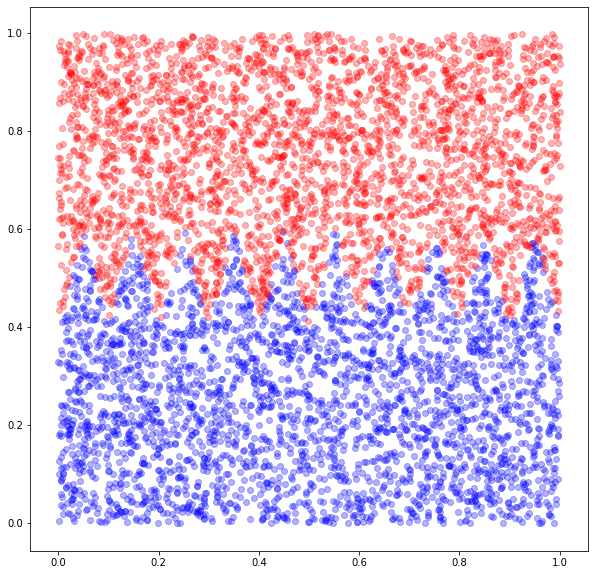

In [10]:
blue_data, red_data = generate_saw(6000, 0.05, 0.1)
plot_model_data(blue_data, red_data)

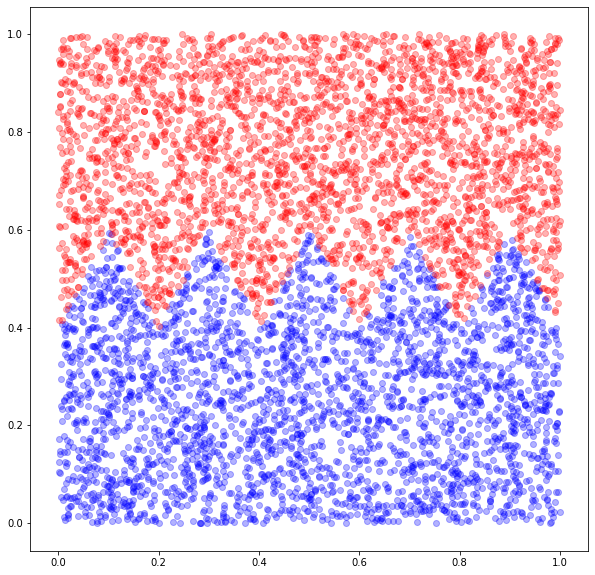

In [11]:
blue_data, red_data = generate_saw(6000, 0.1, 0.1)
plot_model_data(blue_data, red_data)

In [12]:
def generate_gaussian(point_count, mu, transform_matrix):
    """V = transform_matrix
    function: X = mu + V.T x X
    output: Normal(mu, V.T x V)
    """
    points = np.random.randn(point_count, 2)
    points = mu + np.dot(transform_matrix.T, points.T).T
    return points

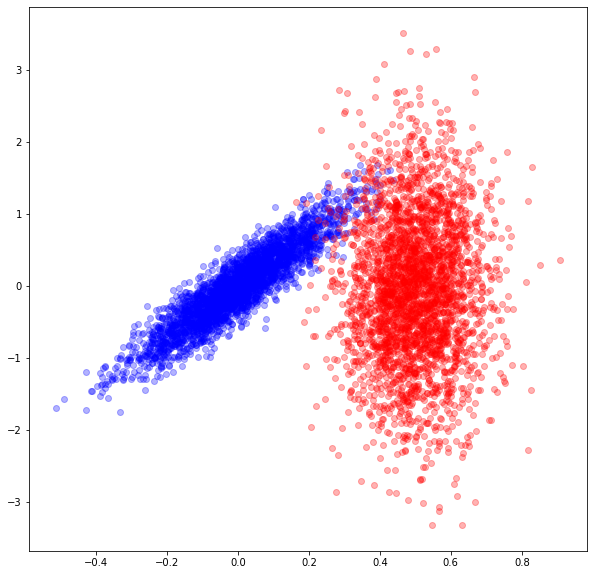

In [13]:
blue_data = generate_gaussian(3000, (0, 0), np.array([[0.1, 0.2], [0.1, 0.5]]))
red_data = generate_gaussian(3000, (0.5, 0), np.array([[0.1, 0], [0, 1.0]]))
plot_model_data(blue_data, red_data)

# Домашнее задание (базовое):

# Задание 1.

Напишите программу эквивалентную упражнению 3, но для произвольного числа слоёв в нейронной сети.

# Задание 2.

Используйте имеющиеся у вас программы для обучения нейронных сетей для примеров рассмотренных пункте 4 множеств данных и протестируйте их.

# Задание 3.

Постройте линию разделения множеств для нейронных сетй из предыдущего задания.

# Домашнее задание (дополнительное):

# Задание. Крепкие сети.

Реализуйте алгоритм обучения с подкреплением Q-learning 

(https://ru.wikipedia.org/wiki/Q-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5). 

Напишите с её помощью искуственный интелект для игры в крестики-нолики.

In [5]:
import numpy as np
import csv
import random
from itertools import groupby

class TicTacToeGame():
    def __init__(self):
        self.state = '         '
        self.player = 'X'
        self.winner = None

    def allowed_moves(self):
        states = []
        for i in range(len(self.state)):
            if self.state[i] == ' ':
                states.append(self.state[:i] + self.player + self.state[i+1:])
        return states

    def make_move(self, next_state):
        if self.winner:
            raise(Exception("Game already completed, cannot make another move!"))
        if not self.__valid_move(next_state):
            raise(Exception("Cannot make move {} to {} for player {}".format(
                    self.state, next_state, self.player)))

        self.state = next_state
        self.winner = self.predict_winner(self.state)
        if self.winner:
            self.player = None
        elif self.player == 'X':
            self.player = 'O'
        else:
            self.player = 'X'

    def playable(self):
        return ( (not self.winner) and any(self.allowed_moves()) )

    def predict_winner(self, state):
        lines = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        winner = None
        for line in lines:
            line_state = state[line[0]] + state[line[1]] + state[line[2]]
            if line_state == 'XXX':
                winner = 'X'
            elif line_state == 'OOO':
                winner = 'O'
        return winner

    def __valid_move(self, next_state):
        allowed_moves = self.allowed_moves()
        if any(state == next_state for state in allowed_moves):
            return True
        return False

    def print_board(self):
        s = self.state
        print('     {} | {} | {} '.format(s[0],s[1],s[2]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[3],s[4],s[5]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[6],s[7],s[8]))


class Agent():
    def __init__(self, game_class, epsilon=0.1, alpha=0.5, value_player='X'):
        self.V = dict()
        self.NewGame = game_class
        self.epsilon = epsilon
        self.alpha = alpha
        self.value_player = value_player

    def state_value(self, game_state):
        return self.V.get(game_state, 0.0)

    def learn_game(self, num_episodes=1000):
        for episode in range(num_episodes):
            self.learn_from_episode()

    def learn_from_episode(self):
        game = self.NewGame()
        _, move = self.learn_select_move(game)
        while move:
            move = self.learn_from_move(game, move)

    def learn_from_move(self, game, move):
        game.make_move(move)
        r = self.__reward(game)
        td_target = r
        next_state_value = 0.0
        selected_next_move = None
        if game.playable():
            best_next_move, selected_next_move = self.learn_select_move(game)
            next_state_value = self.state_value(best_next_move)
        current_state_value = self.state_value(move)
        td_target = r + next_state_value
        self.V[move] = current_state_value + self.alpha * (td_target - current_state_value)
        return selected_next_move

    def learn_select_move(self, game):
        allowed_state_values = self.__state_values( game.allowed_moves() )
        if game.player == self.value_player:
            best_move = self.__argmax_V(allowed_state_values)
        else:
            best_move = self.__argmin_V(allowed_state_values)

        selected_move = best_move
        if random.random() < self.epsilon:
            selected_move = self.__random_V(allowed_state_values)

        return (best_move, selected_move)

    def play_select_move(self, game):
        allowed_state_values = self.__state_values( game.allowed_moves() )
        if game.player == self.value_player:
            return self.__argmax_V(allowed_state_values)
        else:
            return self.__argmin_V(allowed_state_values)

    def demo_game(self, verbose=False):
        game = self.NewGame()
        t = 0
        while game.playable():
            if verbose:
                print(" \nTurn {}\n".format(t))
                game.print_board()
            move = self.play_select_move(game)
            game.make_move(move)
            t += 1
        if verbose:
            print(" \nTurn {}\n".format(t))
            game.print_board()
        if game.winner:
            if verbose:
                print("\n{} is the winner!".format(game.winner))
            return game.winner
        else:
            if verbose:
                print("\nIt's a draw!")
            return '-'

    def interactive_game(self, agent_player='X'):
        game = self.NewGame()
        t = 0
        while game.playable():
            print(" \nTurn {}\n".format(t))
            game.print_board()
            if game.player == agent_player:
                move = self.play_select_move(game)
                game.make_move(move)
            else:
                move = self.__request_human_move(game)
                game.make_move(move)
            t += 1

        print(" \nTurn {}\n".format(t))
        game.print_board()

        if game.winner:
            print("\n{} is the winner!".format(game.winner))
            return game.winner
        print("\nIt's a draw!")
        return '-'

    def round_V(self):
        # After training, this makes action selection random from equally-good choices
        for k in self.V.keys():
            self.V[k] = round(self.V[k],1)

    def save_v_table(self):
        with open('state_values.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['State', 'Value'])
            all_states = list(self.V.keys())
            all_states.sort()
            for state in all_states:
                writer.writerow([state, self.V[state]])

    def __state_values(self, game_states):
        return dict((state, self.state_value(state)) for state in game_states)

    def __argmax_V(self, state_values):
        max_V = max(state_values.values())
        chosen_state = random.choice([state for state, v in state_values.items() if v == max_V])
        return chosen_state

    def __argmin_V(self, state_values):
        min_V = min(state_values.values())
        chosen_state = random.choice([state for state, v in state_values.items() if v == min_V])
        return chosen_state

    def __random_V(self, state_values):
        return random.choice(list(state_values.keys()))

    def __reward(self, game):
        if game.winner == self.value_player:
            return 1.0
        elif game.winner:
            return -1.0
        else:
            return 0.0

    def __request_human_move(self, game):
        allowed_moves = [i+1 for i in range(9) if game.state[i] == ' ']
        human_move = None
        while not human_move:
            idx = int(input('Choose move for {}, from {} : '.format(game.player, allowed_moves)))
            if any([i==idx for i in allowed_moves]):
                human_move = game.state[:idx-1] + game.player + game.state[idx:]
        return human_move

def demo_game_stats(agent):
    results = [agent.demo_game() for i in range(10000)]
    game_stats = {k: results.count(k)/100 for k in ['X', 'O', '-']}
    print("    percentage results: {}".format(game_stats))


    
agent = Agent(TicTacToeGame, epsilon = 0.1, alpha = 1.0)
print("Before learning:")
demo_game_stats(agent)

agent.learn_game(1000)
print("After 1000 learning games:")
demo_game_stats(agent)

agent.learn_game(2000)
print("After 2000 learning games:")
demo_game_stats(agent)

agent.learn_game(3000)
print("After 3000 learning games:")
demo_game_stats(agent)

agent.learn_game(4000)
print("After 4000 learning games:")
demo_game_stats(agent)

agent.learn_game(5000)
print("After 5000 learning games:")
demo_game_stats(agent)

agent.round_V()
agent.save_v_table()

Before learning:
    percentage results: {'X': 58.71, 'O': 28.82, '-': 12.47}
After 1000 learning games:
    percentage results: {'X': 55.6, 'O': 32.32, '-': 12.08}
After 2000 learning games:
    percentage results: {'X': 43.55, 'O': 27.07, '-': 29.38}
After 3000 learning games:
    percentage results: {'X': 11.11, 'O': 4.8, '-': 84.09}
After 4000 learning games:
    percentage results: {'X': 2.66, 'O': 0.57, '-': 96.77}
After 5000 learning games:
    percentage results: {'X': 0.79, 'O': 0.0, '-': 99.21}


In [1]:
theBoard = {'7': ' ' , '8': ' ' , '9': ' ' ,
            '4': ' ' , '5': ' ' , '6': ' ' ,
            '1': ' ' , '2': ' ' , '3': ' ' }

board_keys = []

for key in theBoard:
    board_keys.append(key)

''' We will have to print the updated board after every move in the game and 
    thus we will make a function in which we'll define the printBoard function
    so that we can easily print the board everytime by calling this function. '''

def printBoard(board):
    print(board['7'] + '|' + board['8'] + '|' + board['9'])
    print('-+-+-')
    print(board['4'] + '|' + board['5'] + '|' + board['6'])
    print('-+-+-')
    print(board['1'] + '|' + board['2'] + '|' + board['3'])

def game():

    turn = 'X'
    count = 0


    for i in range(10):
        printBoard(theBoard)
        print("It's your turn," + turn + ".Move to which place?")

        move = input()        

        if theBoard[move] == ' ':
            theBoard[move] = turn
            count += 1
        else:
            print("That place is already filled.\nMove to which place?")
            continue

        # Now we will check if player X or O has won,for every move after 5 moves. 
        if count >= 5:
            if theBoard['7'] == theBoard['8'] == theBoard['9'] != ' ': # across the top
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")                
                break
            elif theBoard['4'] == theBoard['5'] == theBoard['6'] != ' ': # across the middle
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break
            elif theBoard['1'] == theBoard['2'] == theBoard['3'] != ' ': # across the bottom
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break
            elif theBoard['1'] == theBoard['4'] == theBoard['7'] != ' ': # down the left side
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break
            elif theBoard['2'] == theBoard['5'] == theBoard['8'] != ' ': # down the middle
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break
            elif theBoard['3'] == theBoard['6'] == theBoard['9'] != ' ': # down the right side
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break 
            elif theBoard['7'] == theBoard['5'] == theBoard['3'] != ' ': # diagonal
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break
            elif theBoard['1'] == theBoard['5'] == theBoard['9'] != ' ': # diagonal
                printBoard(theBoard)
                print("\nGame Over.\n")                
                print(" **** " +turn + " won. ****")
                break 

        # If neither X nor O wins and the board is full, we'll declare the result as 'tie'.
        if count == 9:
            print("\nGame Over.\n")                
            print("It's a Tie!!")

        # Now we have to change the player after every move.
        if turn =='X':
            turn = 'O'
        else:
            turn = 'X'        
    
    # Now we will ask if player wants to restart the game or not.
    restart = input("Do want to play Again?(y/n)")
    if restart == "y" or restart == "Y":  
        for key in board_keys:
            theBoard[key] = " "
        game()


game()

 | | 
-+-+-
 | | 
-+-+-
 | | 
It's your turn,X.Move to which place?
1
 | | 
-+-+-
 | | 
-+-+-
X| | 
It's your turn,O.Move to which place?
6
 | | 
-+-+-
 | |O
-+-+-
X| | 
It's your turn,X.Move to which place?
4
 | | 
-+-+-
X| |O
-+-+-
X| | 
It's your turn,O.Move to which place?
8
 |O| 
-+-+-
X| |O
-+-+-
X| | 
It's your turn,X.Move to which place?
7
X|O| 
-+-+-
X| |O
-+-+-
X| | 

Game Over.

 **** X won. ****
Do want to play Again?(y/n)n
